In [2]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14682497042838096147
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7518434078961476723
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, utils

# attention mask 시각화를 위한 모듈
from bertviz import model_view
utils.logging.set_verbosity_error()


from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [5]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
url='./data/service_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,en_ParkChaletGardenRestaurant_477778210:3,When I got there I sat up stairs where the atm...,service,0
1,en_MercedesRestaurant_478010603:4,Can get busy on Fridays for a table but once s...,service,1
2,3511,"A gentleman, maybe the manager, came to our ta...",service,0
3,2846,"Not only was the food outstanding, but the lit...",service,1
4,en_SchoonerOrLater_477965850:7,A brief conversation with the manager at the e...,service,0


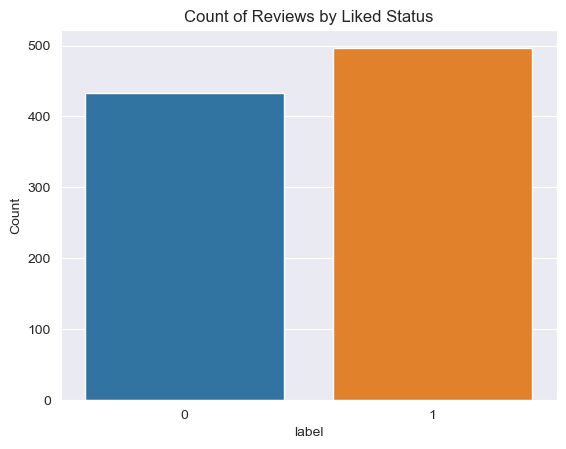

In [6]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [7]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 497, negative: 433


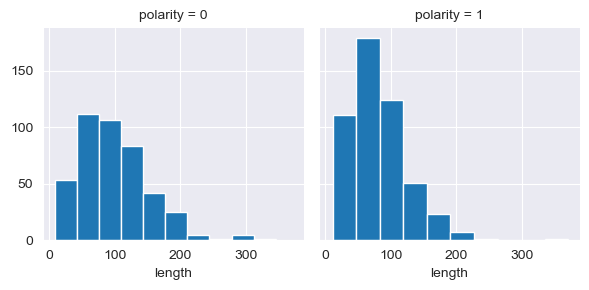

In [8]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

# Create a FacetGrid object with 'Liked' as the column to be used for separating the data
# FacetGrid is a grid of subplots that displays the same relationship between different subsets of your data.
g = sns.FacetGrid(df, col='polarity')

# Use the FacetGrid object to plot a histogram of the 'Length' column for each value of 'Liked'
g.map(plt.hist, 'length');

In [9]:
df_new.length.describe()

count    930.000000
mean      90.240860
std       49.354521
min        9.000000
25%       54.000000
50%       82.000000
75%      116.750000
max      370.000000
Name: length, dtype: float64

In [10]:
text = df.text.values
labels = df.polarity.values

In [11]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [12]:
# 토큰마다 ID가 어떻게 부여되는지 보자
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ she      │        2016 │
├──────────┼─────────────┤
│ just     │        2074 │
├──────────┼─────────────┤
│ nodded   │        3368 │
├──────────┼─────────────┤
│ and      │        1998 │
├──────────┼─────────────┤
│ walked   │        2939 │
├──────────┼─────────────┤
│ off      │        2125 │
├──────────┼─────────────┤
│ .        │        1012 │
╘══════════╧═════════════╛


In [13]:
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [55]:
token_id[6]

tensor([  101,  1045,  2001,  2471, 11770,  2011,  1996,  2755,  2008,  2016,
         2001,  3810,  2185,  6304,  2012,  1023,  9737,  2006,  1037,  5958,
         2305,  2138,  2016,  1000,  2018,  1037, 22861,  4160,  2000,  2175,
         2000,  1000,  2008,  2305,  1011,  1059, 24475,  1029,  1029,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [14]:
# 토큰 ID와 attention mask가 잘 추출 되었는지 보자
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒═════════════╤═════════════╤══════════════════╕
│ Tokens      │   Token IDs │   Attention Mask │
╞═════════════╪═════════════╪══════════════════╡
│ [CLS]       │         101 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ service     │        2326 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ was         │        2001 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ awful       │        9643 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ -           │        1011 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ mostly      │        3262 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ because     │        2138 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ staff       │        3095 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ were        │        2020 │                1 │
├─────────────┼─────

In [14]:
VAL_RATIO= 0.2
batch_size = 8 # 16 or 32 추천이라고 한다

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 744
validation: 186


In [15]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [20]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [21]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 15

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:   7%|█████                                                                       | 1/15 [00:07<01:39,  7.10s/it]


	 - Train loss: 0.4281
	 - Validation Accuracy: 0.9010


Epoch:  13%|██████████▏                                                                 | 2/15 [00:13<01:30,  6.95s/it]


	 - Train loss: 0.1719
	 - Validation Accuracy: 0.8906


Epoch:  20%|███████████████▏                                                            | 3/15 [00:20<01:22,  6.90s/it]


	 - Train loss: 0.0552
	 - Validation Accuracy: 0.8854


Epoch:  27%|████████████████████▎                                                       | 4/15 [00:27<01:15,  6.88s/it]


	 - Train loss: 0.0471
	 - Validation Accuracy: 0.8750


Epoch:  33%|█████████████████████████▎                                                  | 5/15 [00:34<01:08,  6.88s/it]


	 - Train loss: 0.0548
	 - Validation Accuracy: 0.8906


Epoch:  40%|██████████████████████████████▍                                             | 6/15 [00:41<01:01,  6.88s/it]


	 - Train loss: 0.0024
	 - Validation Accuracy: 0.8854


Epoch:  47%|███████████████████████████████████▍                                        | 7/15 [00:48<00:55,  6.88s/it]


	 - Train loss: 0.0007
	 - Validation Accuracy: 0.8854


Epoch:  53%|████████████████████████████████████████▌                                   | 8/15 [00:55<00:48,  6.88s/it]


	 - Train loss: 0.0004
	 - Validation Accuracy: 0.8854


Epoch:  60%|█████████████████████████████████████████████▌                              | 9/15 [01:02<00:41,  6.89s/it]


	 - Train loss: 0.0003
	 - Validation Accuracy: 0.8854


Epoch:  67%|██████████████████████████████████████████████████                         | 10/15 [01:08<00:34,  6.90s/it]


	 - Train loss: 0.0002
	 - Validation Accuracy: 0.8854


Epoch:  73%|██████████████████████████████████████████████████████▉                    | 11/15 [01:15<00:27,  6.90s/it]


	 - Train loss: 0.0002
	 - Validation Accuracy: 0.8854


Epoch:  80%|████████████████████████████████████████████████████████████               | 12/15 [01:22<00:20,  6.90s/it]


	 - Train loss: 0.0002
	 - Validation Accuracy: 0.8854


Epoch:  87%|█████████████████████████████████████████████████████████████████          | 13/15 [01:29<00:13,  6.91s/it]


	 - Train loss: 0.0001
	 - Validation Accuracy: 0.8854


Epoch:  93%|██████████████████████████████████████████████████████████████████████     | 14/15 [01:36<00:06,  6.91s/it]


	 - Train loss: 0.0001
	 - Validation Accuracy: 0.8854


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 15/15 [01:43<00:00,  6.90s/it]


	 - Train loss: 0.0001
	 - Validation Accuracy: 0.8854


In [18]:
print(epo_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [19]:
print(train_loss_list)

[0.4375, 0.1637, 0.0797, 0.0627, 0.0293, 0.0059, 0.0224, 0.0345, 0.0058, 0.0004]


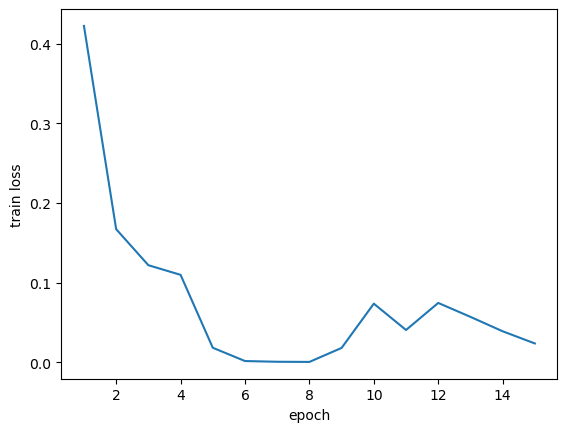

In [14]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

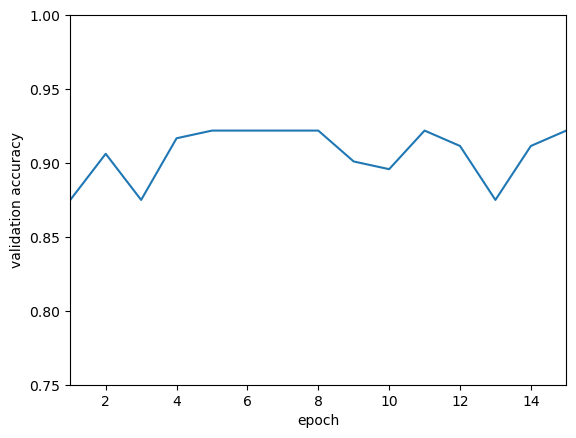

In [15]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [22]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='food was delicious, but the staff was not kind.'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: food was delicious, but the staff was not kind.
분류: Negative


In [23]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/service_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)


,id,text,polarity
0,33068635#1533725#2,The food is very good and the service is great.,1
1,35820984#608922#3,The staff is very sharp and they look good too.,1
2,11351819#985076#2,Waiting three hours before getting our entrees...,0
3,en_MiopostoCaffe_478542919:5,"Finally, my wife stood face to face in front o...",0
4,en_MiopostoCaffe_478542919:4,We stood there for 10 minutes while employees ...,0


In [24]:
df_new=df
df_new['length'] = df['text'].apply(len)
df_new.length.describe()

count    100.000
mean      86.900
std       45.612
min       15.000
25%       56.000
50%       76.000
75%      107.250
max      266.000
Name: length, dtype: float64

In [25]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 52, negative: 48


In [26]:
count=0

test_text = df.text.values
test_labels = df.polarity.values

wrongResult=[]
rightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        rightResult.append(t)
    else:
        wrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
The food is very good and the service is great.
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
The staff is very sharp and they look good too.
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
Waiting three hours before getting our entrees was a treat as well.
model result: Positive 
answer: 0 

=============================== Input 4 ===============================
Finally, my wife stood face to face in front of one of the staff and she asked, "Are you waiting for a table?"
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
We stood there for 10 minutes while employees walked back and forth ignoring us.
model result: Negative 
answer: 0 

=============================== Input 6 ===============================
The service is pretty good.
mode

=============================== Input 79 ===============================
What a difference, the service was very comforting and the food was better than average, but what really standed out was such a dynamic and extensive beer list.
model result: Positive 
answer: 1 

=============================== Input 80 ===============================
The service was outstanding.
model result: Positive 
answer: 1 

=============================== Input 81 ===============================
The waiters are very friendly and helpful and if you frequent they will remember you.
model result: Positive 
answer: 1 

=============================== Input 82 ===============================
I highly recommend it for not just its superb cuisine, but also for its friendly owners and staff.
model result: Positive 
answer: 1 

=============================== Input 83 ===============================
After I paid for my purchase, I noticed they had not given me utensils so I could eat my pie.
model result: Negative

In [22]:
print(wrongResult)

['Waiting three hours before getting our entrees was a treat as well.', 'Service is known for bending over backwards to make everyone happy.', 'I HAVE NEVER HAD A BAD MEAL(OR BAD SERVICE )@ PIGALLE.', "If I want to stand in line on Sunday for an hour to get average brunch food, then I would put Murphy's at the top of the list."]


In [27]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [28]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [29]:
# 개별 문장의 attention 추출
from bertviz import head_view

sent="Terrible service, but cheap and reasonable price."

# 전처리
encoding = preprocessing(sent, tokenizer,10)


retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

print('입력 문장:', sent)
print('분류:', prediction)
print()

head_view(retAtt,retTok)


입력 문장: Terrible service, but cheap and reasonable price.
분류: Negative



<IPython.core.display.Javascript object>

In [30]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [31]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [32]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [33]:
# 개별 문장을 attention이 높은 token 순으로 보여주기
idxs=sort_by_att(retLastAtt,retTok)

emp_by_att(idxs,retTok)

get_highest_att_tok(idxs,retTok,3)

========================= emphasize by attention result==========================
terrible service , but cheap and reasonable price 
highest attention: terrible but service 

In [27]:
#잘못 분류된 문장의 attention
for sent in wrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: Waiting three hours before getting our entrees was a treat as well.
분류: Positive
MAX_LEN:  17
========================= emphasize by attention result==========================
waiting three hours before getting our en ##tree ##s was a treat as well . 
highest attention: was well getting as 



입력 문장: the food was great, the margaritas too but the waitress was too busy being nice to her other larger party than to take better care of my friend and me.
분류: Positive
MAX_LEN:  35
========================= emphasize by attention result==========================
the food was great , the margarita ##s too but the waitress was too busy being nice to her other larger party than to take better care of my friend and me . 
highest attention: but busy was was 



입력 문장: I HAVE NEVER HAD A BAD MEAL(OR BAD SERVICE )@ PIGALLE.
분류: Negative
MAX_LEN:  18
========================= emphasize by attention result==========================
i have never had a bad meal ( or bad service ) @ pig ##alle . 


In [91]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_service_test.csv'
df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
df.head(5)

,id,category,text,polarity,trans_text
0,1546,service,직원이 친절하지 않습니다. \n음식이 조금 짠 편이고 가격대비는 글쎄요…,0,The staff is not friendly. The food is a littl...
1,101,service,언제나처럼 맛 그대로고 직원분들 친절하시고\n오래간만에 어린이 김밥과 쫄면 포장 잘...,1,"As always, the taste is the same and the staff..."
2,1543,service,오래전부터 단골이었는데\n가격 올리면서 고기양은 줄어들고 퀄리티는 낮아졌습니다. 직...,0,I've been a regular for a long time. As the pr...
3,88,service,음... 정말 맛있네요.\n김밥 정말 깔끔하고 맛있어요.\n야채도 듬뿍 넣어주시고요...,1,"Well, it's really good.. Kimbap is very clean ..."
4,155,service,야미야미 들리셔스 했습니다! 매장 청결 하고 매우 친절 하시고 맛도 있어요 근처 사...,1,"Yummy, yummy. I heard it! The store is clean, ..."


In [92]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count    100.000000
mean     103.880000
std       59.416571
min       17.000000
25%       49.750000
50%       93.500000
75%      151.500000
max      217.000000
Name: length, dtype: float64

In [93]:
# naver data에 대한 분류 및 accuracy 측정
count=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))

=============================== Input 1 ===============================
The staff is not friendly. The food is a little salty and I don't know about the price…
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
As always, the taste is the same and the staff are kind. It's been a long time since I packed children's gimbap and jjolmyeon well.Good luck!
model result: Positive 
answer: 1 

=============================== Input 3 ===============================
I've been a regular for a long time. As the price increased, the amount of meat decreased and the quality decreased. The employees are not very good-natured either. The service is the worst.  I won't visit again.
model result: Negative 
answer: 0 

=============================== Input 4 ===============================
Well, it's really good.. Kimbap is very clean and delicious.. Please add lots of vegetables.. Nice and quick response. Good
model result: Positive 
answer: 1 

=

=============================== Input 46 ===============================
I think it's an Indian couple, but they're kind and generous
model result: Positive 
answer: 1 

=============================== Input 47 ===============================
He's always so kind, so I use it often It's my first time trying lemonade and it's really good   It makes me want to visit often
model result: Positive 
answer: 1 

=============================== Input 48 ===============================
I'm not that kind
model result: Negative 
answer: 0 

=============================== Input 49 ===============================
It's good, but the staff is so unfriendly
model result: Positive 
answer: 0 

=============================== Input 50 ===============================
The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
model result: Negative 
answer: 0 

=============================== Input 51 ===============================
He's kind an

In [94]:
#잘못 분류된 문장의 attention
for sent in NaverWrongResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: It's unkind. It's good
분류: Positive
MAX_LEN:  12
========================= emphasize by attention result==========================
it ' s un ##kind . it ' s good 
highest attention: good un ##kind s 



입력 문장: Kimbap itself is so good  The staff members are so unkind
분류: Positive
MAX_LEN:  16
========================= emphasize by attention result==========================
kim ##ba ##p itself is so good the staff members are so un ##kind 
highest attention: the are good members 



입력 문장: I don't know why it's delicious.. The female boss is very unkind.. Business is so good that you don't seem to feel the need to be kind
분류: Positive
MAX_LEN:  40
========================= emphasize by attention result==========================
i don ' t know why it ' s delicious . . the female boss is very un ##kind . . business is so good that you don ' t seem to feel the need to be kind 
highest attention: ' ' ' the 



입력 문장: Kalguksu Dumpling Bibim is all delicious Of course, the price is hi

In [95]:
#잘 분류된 문장의 attention
for sent in NaverRightResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: The staff is not friendly. The food is a little salty and I don't know about the price…
분류: Negative
MAX_LEN:  24
========================= emphasize by attention result==========================
the staff is not friendly . the food is a little salty and i don ' t know about the price … 
highest attention: ' the is about 



입력 문장: As always, the taste is the same and the staff are kind. It's been a long time since I packed children's gimbap and jjolmyeon well.Good luck!
분류: Positive
MAX_LEN:  42
========================= emphasize by attention result==========================
as always , the taste is the same and the staff are kind . it ' s been a long time since i packed children ' s gi ##mba ##p and jj ##ol ##my ##eon well . good luck ! 
highest attention: ' same kind are 



입력 문장: I've been a regular for a long time. As the price increased, the amount of meat decreased and the quality decreased. The employees are not very good-natured either. The service is the worst.  I wo

========================= emphasize by attention result==========================
it ' s delicious even though it ' s packed . if you gave me a lot of na ##an and ate two meals , ra was delicious and kind . 
highest attention: even kind if packed 



입력 문장: Sweet pumpkin soup tastes good, but it's not kind
분류: Negative
MAX_LEN:  14
========================= emphasize by attention result==========================
sweet pumpkin soup tastes good , but it ' s not kind 
highest attention: but not s ' 



입력 문장: It tastes good.. . I don't know if it's just us, but... There was a bad smell on the table.. . I want you to pay attention to cleaning the table.
분류: Negative
MAX_LEN:  46
========================= emphasize by attention result==========================
it tastes good . . . i don ' t know if it ' s just us , but . . . there was a bad smell on the table . . . i want you to pay attention to cleaning the table . 
highest attention: ' a was there 



입력 문장: It's so nice. I want to come a

========================= emphasize by attention result==========================
i went to lunch with my mother today , and both pork cut ##let and char si ##u over rice were delicious , and above all , the boss is really kind ! thank you for the delicious meal 
highest attention: kind delicious and is 



입력 문장: Honestly, the taste isn't that special It's very expensive It's not cleaned yet You only cared about the interior. It wouldn't be a waste of money if it was not kind and delicious
분류: Negative
MAX_LEN:  45
========================= emphasize by attention result==========================
honestly , the taste isn ' t that special it ' s very expensive it ' s not cleaned yet you only cared about the interior . it wouldn ' t be a waste of money if it was not kind and delicious 
highest attention: ' ' honestly yet 



입력 문장: I was frustrated because there was no ringing bell
분류: Negative
MAX_LEN:  11
========================= emphasize by attention result==========================

========================= emphasize by attention result==========================
first of all , the food is so good parking is convenient , the store is comfortable , the owner is kind , and there is no reason not to come . . 
highest attention: convenient kind is comfortable 



입력 문장: I couldn't eat it because I was waiting a long time ago, but I came here to eat it on purpose It's annoying to hear the loud noise in the kitchen
분류: Negative
MAX_LEN:  38
========================= emphasize by attention result==========================
i couldn ' t eat it because i was waiting a long time ago , but i came here to eat it on purpose it ' s annoying to hear the loud noise in the kitchen 
highest attention: ' but because the 



입력 문장: It tastes good, but it's not friendly
분류: Negative
MAX_LEN:  12
========================= emphasize by attention result==========================
it tastes good , but it ' s not friendly 
highest attention: but s not ' 



입력 문장: It was good, but compared t

========================= emphasize by attention result==========================
there are so many delicious bread ##s . kind and neat . there are a lot of topping ##s . i like it 
highest attention: kind neat and it 



입력 문장: All the food is good, especially. The female employee who received the order is kind and nice.
분류: Positive
MAX_LEN:  22
========================= emphasize by attention result==========================
all the food is good , especially . the female employee who received the order is kind and nice . 
highest attention: kind the female good 



입력 문장: I really drank a lot here. The part-timer and the owner are kind and the atmosphere is great. The taste. The taste is the base! I want to come here often! That's amazing. I'll come back next time^^
분류: Positive
MAX_LEN:  54
========================= emphasize by attention result==========================
i really drank a lot here . the part - timer and the owner are kind and the atmosphere is great . the taste . th

In [96]:
#NAVER final test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_fin_service_trans.csv'
df = pd.read_csv(test_url,sep=',', header=0)
df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,160,service,"평양냉면이 정말 맛있어요. 평양냉면, 온반 하나씩 시켜서 먹었는데 온반은 삼삼하고 ...",1,Pyeongyang naengmyeon is really good. I ordere...
1,1,161,service,유튜브에서 평양냉면보고 갑자기 너무 땡겨서 먹고 왔어요! \n\n친구 올 때까지 기...,1,I watched Pyeongyang naengmyeon on YouTube and...
2,2,162,service,가격은 좀 나가지만 식당 내부 깔끔하고 친절하고 무엇보다 맛있어요,1,"It's a little expensive, but the inside of the..."
3,3,163,service,평양냉면(물)과 만두한접시. 만두는 옛날 할머니가해주시던맛. 두부소으깨서 고기와들어...,1,Pyeongyang naengmyeon (water) and a plate of d...
4,4,164,service,깨끗하고 건강한맛. 주차가 불편함. 친절하지는 않음,0,a clean and healthy taste. Parking is inconven...


In [97]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count     23.000000
mean     282.304348
std      234.558276
min       43.000000
25%      107.500000
50%      174.000000
75%      382.500000
max      784.000000
Name: length, dtype: float64

In [98]:
# naver data에 대한 분류 및 accuracy 측정
count=0

negNum=0
posNum=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
        negNum+=1
    else:
        result=1
        posNum+=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
print("Positive ratio: {:.4f}".format(posNum/len(test_labels)))
print("Negative ratio: {:.4f}".format(negNum/len(test_labels)))

=============================== Input 1 ===============================
Pyeongyang naengmyeon is really good. I ordered Pyeongyang naengmyeon and an onban, but the onban was samgyupsal and hot, so I felt so comfortable. Will the two be a good combination? I tried it, but each one was so good that I ate it well.  The staff are so kind, so I recommend it!!
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
I watched Pyeongyang naengmyeon on YouTube and I suddenly craved it, so I ate it! I waited until my friend came and ordered it, but it was good that it was processed so that it could come out on time.. . And I sold mung bean pancake and dumplings individually, so I ordered just enough and ate them allThe staff were kind and the food was delicious, but the sad thing was that the distance between the tables was too close and the drunk men were noisy, so my ears hurt(Crying) (Crying) But the staff restrained me a little bit. Thank y

In [26]:
#잘못 분류된 문장의 attention
for sent in NaverWrongResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: a clean and healthy taste. Parking is inconvenient. Not kind enough
분류: Positive
MAX_LEN:  18
========================= emphasize by attention result==========================
a clean and healthy taste . parking is inc ##on ##ven ##ient . not kind enough 
highest attention: inc is ##ient not 



입력 문장: I like Pyeongyang naengmyeon and go around looking for good restaurants. Unkind first impression! As soon as I was about to understand, I thought restaurants must be unfriendly, but I ordered mulnaengmyeon + Pyeonyuk. A twist here! If it was unkind but not tasty!! It's not to the point where it's not bad, but below the level!! The broth is very seasoned! There's no deep taste!  Until the fishy smell! Every bowl has traces of a lady's thumb slipping into the broth! The price is more expensive than thunderbolt or Pildongmyeonok!! I'm seriously going to lose my hands!!! The fact that there are so many customers is so strange that I analyzed it and found that there are many places to 

In [40]:
#naver3 data 테스트

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/mongryen_service.csv'
df = pd.read_csv(test_url,sep=',', header=0)
df.head(5)

,id,category,text,trans_text
0,769,service,결과부터 말하자만 너무 기대가 컸던 탓인지 다시는 가고 싶지 않을 정도로 불쾌했다....,"Let me tell you the results first, but I was s..."
1,770,service,친절하시고 고기도 맛있어요,He's kind and the meat is good too
2,771,service,저녁 9인 예약하고 8인이 방문했습니다. 3/3/3 자리 셋팅으로 한명이 오지않아 ...,I made a reservation for 9 people in the eveni...
3,772,service,"서버분이 집기달라는 말에 한번에 좀 말씀해주시겠어요 하고 짜증내시는 부분에서, 이 ...","When the server asked me to pick it up, he sai..."
4,773,service,매장이 청결하고 직원분들도 친절하고 고기도 맛있습니다. 특히 냄새가 옷에 남지않아 ...,"The store is clean, the staff is kind, and the..."


In [41]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count    241.000000
mean     237.257261
std      222.016141
min        8.000000
25%       80.000000
50%      158.000000
75%      294.000000
max      973.000000
Name: length, dtype: float64

In [42]:
# naver data에 대한 분류
count=0

negNum=0
posNum=0

test_text = df.trans_text.values

for i in range(len(test_text)):
    t = df.iloc[i].trans_text
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        negNum+=1
    else:
        posNum+=1

    print("=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction)
    print("")


print("Positive ratio: {:.4f}".format(posNum/len(test_text)))
print("Negative ratio: {:.4f}".format(negNum/len(test_text)))

=============================== Input 1 ===============================
Let me tell you the results first, but I was so unpleasant that I didn't want to go again, maybe because I had high expectations. From the time I inquired on the wire, the lady's chilly attitude was enough to be unpleasant, but after arriving, she did not accept the order for a long time, saying that she was busy responding to the table. But I thought everything would be offset if the food was delicious, but he was also mistaken. The taste of the food was okay, and the response of the server was not good.. If you're this busy, shouldn't you at least limit the number of customers or hire more servers.. Even if you leave a review like this, you will go, but I leave a review in the hope that you will think about it at least once when someone tries to visit this place.
model result: Negative

=============================== Input 2 ===============================
He's kind and the meat is good too
model result: Positiv

=============================== Input 30 ===============================
I made a reservation because I wanted to buy delicious meat for the staff. The group seats were separated from the hall, so it was private and the service was excellent. Axe meat and pork belly are both popular, so I ate a lot^^*. Beef tartare was also delicious, so I emptied four plates. They also cut the meat sashimi. Fresh meat slaughtered on the day was the best! I think I'll come to Mongryeon again at the next get-together!
model result: Positive

=============================== Input 31 ===============================
Honestly, the food is good and the staff is kind! Make sure to eat doenjang jjigae and fried rice twice. But if it's this much, other restaurants can cook it for you... It's uncomfortable to grill and eat..crying.
model result: Positive

=============================== Input 32 ===============================
I want the staff on the second floor to be kind...You're scolding meㅜㅠ
model result: N

=============================== Input 64 ===============================
The service is so messed up, especially the waitress... I get 20,000 won from the 2nd bottle free of charge, but the service is only ice, no glasses, and I enjoy the wine, so I carry a glass with me.. As soon as I saw the first two bottles, if I kept drinking two bottles or opening the bottle, if I was too bothered by eating, I would have won two bottles on my own, but if I just dipped it in the catcher, I would have paid on my own... If you want to order more, your mind disappears. I want an independent space for more than 6 people, so the second floor is more independent, so I made a reservation, but if you can't because it's cold over the phone, please take it out of the reservation... I should've gone somewhere else. I often drink coke, so I'm a free-in restaurant. I'm a person who gives tips to the servers to drink coffee when I come out, but I felt really bad. The lady server who cared about the table was ki

=============================== Input 99 ===============================
I ate ax meat for lunch after the meeting, and the meat is really good for lunch, too..I was a bit embarrassed with the meeting manager while waiting for the meat to come out late because of the process of first harvesting...^^;; Four of us ordered meat, fried rice, and cold noodles. We were satisfied with everything~~  He was kind to me, and he explained it to me..You said the fried rice is a bit spicy..It wasn't spicy at all It was delicious
model result: Negative

=============================== Input 100 ===============================
The boss is cool. Please do me a favor. ^^ Each and every DP you feel passionate about. I'll go again when it rains if I get along with her.
model result: Negative

=============================== Input 101 ===============================
The taste is delicious, but above all, the boss was so kind!! You enjoyed both your eyes and mouth. I'll be back next time!!!
model result: Po

=============================== Input 131 ===============================
The meat tastes good and the staff are so kind
model result: Positive

=============================== Input 132 ===============================
The seat on the second floor was quiet and nice.. Pork was more delicious than beef, and I liked the spicy salted seafood with sauce.. However, there was no meat-grilling service at all, and the part-timers were less skilled than other meat restaurants.
model result: Negative

=============================== Input 133 ===============================
The meat was delicious and the staff were kind, so I went looking forward to it.. It was disappointing in many ways. Compared to the price, there was little care from the staff, and the ax meat tasted just like that compared to the big expectations.. Beef brisket doenjang was good to eat. In the 3 additional sets of Jeju pigs ordered, hair came out and was bitten right away, and the cutting condition of the new meat did not l

=============================== Input 161 ===============================
I went with my child, and he was so kind and the food was so delicious!!!^^
model result: Positive

=============================== Input 162 ===============================
The atmosphere was good, the meat was really good, the staff was kind, and everything was good, but it was very hot. I think I'll visit again.
model result: Positive

=============================== Input 163 ===============================
Parking is a little uncomfortable and I made a reservation for 3 people on Naver, but when I went there, only 2 people were set up. It's delicious and kind, but the number of servers on the second floor is so low that even if there's something you need, the response is slow.
model result: Negative

=============================== Input 164 ===============================
The meat was delicious and there were many customers, but it was good that the serving staff responded kindly. I'm willing to revisit.
mo

=============================== Input 197 ===============================
It was my second visit since I went there in the early days of the opening, but the service due to some trouble in the early days was a disadvantage, and now the quality is down. There was not much difference in the taste of food, but the type and quality of side dishes were reduced compared to the early days, and the meat was not cooked well because it was grilled only with charcoal. General comment: The service was better than the early days, but the food was not good, or I just wanted to try it in a building with a unique appearance
model result: Negative

=============================== Input 198 ===============================
The meat was a little small, but it was delicious The atmosphere and interior were good, but in terms of service, it looked a bit immature And poached herring roe fried rice was spicy and delicious
model result: Positive

=============================== Input 199 ======================

=============================== Input 231 ===============================
It was okay! I think it was better because it was a room.. They're all so kind! It's good to have a company dinner
model result: Positive

=============================== Input 232 ===============================
Delicious and good service. It was a bit loud
model result: Positive

=============================== Input 233 ===============================
It's so delicious. I made a reservation and they prepared a window seat on their own. The beer was good, too. The interior of the store was very clean. The staff are kind, too. We're going to go again next time
model result: Positive

=============================== Input 234 ===============================
I was really satisfied It was a little expensive to eat two servings of five-pork belly and cold noodles, but the quality was good enough and the service was good I'll visit again next time!
model result: Positive

=============================== Input 235 ===